# Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense , Dropout
from sklearn.metrics import mean_squared_error,r2_score
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os

# Setting Base Path for File Operations.

In [4]:
def set_base_path(base_path):
    """
    Set the base path for file operations.

    Parameters:
    - base_path (str): The base path to set.

    Returns:
    - None
    """
    global BASE_PATH
    BASE_PATH = base_path

def construct_file_path(relative_path):
    """
    Construct the full file path using the base path and the relative path.

    Parameters:
    - relative_path (str): The relative path from the base path.

    Returns:
    - full_path (str): The full file path.
    """
    if 'BASE_PATH' not in globals():
        raise ValueError("Base path is not set. Call set_base_path() first.")

    full_path = os.path.join(BASE_PATH, relative_path)
    return full_path

# usage
set_base_path(r"F:\DataScience\code\stock-prediction")

# Load Data

In [5]:
# Construct the full file path for data/data.csv
file_path = construct_file_path("data/AAPL_use.csv")

# Now you can use file_path to read the CSV file
data = pd.read_csv(file_path)

print(data)

            Date        Open        High         Low       Close   Adj Close  \
0     10/30/2007    6.649286    6.763214    6.597500    6.678571    5.668749   
1     10/31/2007    6.701071    6.790000    6.605357    6.783929    5.758174   
2      11/1/2007    6.735714    6.789286    6.428571    6.694286    5.682087   
3      11/2/2007    6.757500    6.765714    6.553214    6.709643    5.695121   
4      11/5/2007    6.617500    6.748571    6.580000    6.649286    5.643891   
...          ...         ...         ...         ...         ...         ...   
4022  10/23/2023  170.910004  174.009995  169.929993  173.000000  173.000000   
4023  10/24/2023  173.050003  173.669998  171.449997  173.440002  173.440002   
4024  10/25/2023  171.880005  173.059998  170.649994  171.100006  171.100006   
4025  10/26/2023  170.369995  171.380005  165.669998  166.889999  166.889999   
4026  10/27/2023  166.910004  168.960007  166.830002  168.220001  168.220001   

          Volume  
0      939414000  
1

# Data Preprocessing

In [6]:
# Check for missing values
missing_values = data.isnull().sum()

# Display the count of missing values for each column
print("Missing Values:")
print(missing_values)

# Check if any missing values are found
if missing_values.any():
    print("\nThere are missing values in the dataset.")
else:
    print("\nNo missing values found in the dataset.")

# Removing %h-%m-%s From Date Column
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].dt.strftime('%d-%m-%Y')
data

Missing Values:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

No missing values found in the dataset.


,Date,Open,High,Low,Close,Adj Close,Volume
0,30-10-2007,6.649286,6.763214,6.597500,6.678571,5.668749,939414000
1,31-10-2007,6.701071,6.790000,6.605357,6.783929,5.758174,833310800
2,01-11-2007,6.735714,6.789286,6.428571,6.694286,5.682087,805036400
3,02-11-2007,6.757500,6.765714,6.553214,6.709643,5.695121,1002114400
4,05-11-2007,6.617500,6.748571,6.580000,6.649286,5.643891,804176800
...,...,...,...,...,...,...,...
4022,23-10-2023,170.910004,174.009995,169.929993,173.000000,173.000000,55980100
4023,24-10-2023,173.050003,173.669998,171.449997,173.440002,173.440002,43816600
4024,25-10-2023,171.880005,173.059998,170.649994,171.100006,171.100006,57157000
4025,26-10-2023,170.369995,171.380005,165.669998,166.889999,166.889999,70625300


In [7]:
# Checking The Type Of Data Column(object)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4027 entries, 0 to 4026
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4027 non-null   object 
 1   Open       4027 non-null   float64
 2   High       4027 non-null   float64
 3   Low        4027 non-null   float64
 4   Close      4027 non-null   float64
 5   Adj Close  4027 non-null   float64
 6   Volume     4027 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 220.4+ KB


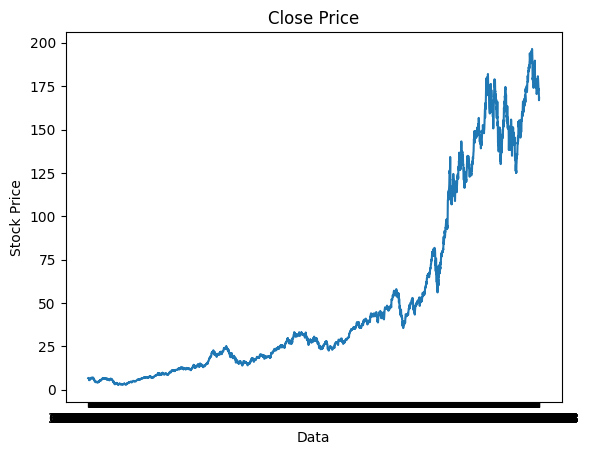

In [8]:
plt.plot(data['Date'],data['Close'])
plt.title('Close Price')
plt.xlabel('Data')
plt.ylabel('Stock Price')
plt.show()

In [9]:
data.shape

(4027, 7)

# Normalization

In [10]:
# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
scaled_data

array([[0.02006491],
       [0.02060896],
       [0.02014606],
       ...,
       [0.8690986 ],
       [0.84735911],
       [0.85422693]])

# Data Preparation

In [11]:
# Define input sequence length and target sequence length
sequence_length = 50 # Number of previous days to consider for prediction
target_length = 1  # Predicting only one day ahead 

In [12]:
    """
    Prepare the data for sequence modeling by converting an array of values into a dataset matrix.

    Parameters:
    - data: The input data as a numpy array.
    - time_steps: The number of time steps to consider for each sample.

    Returns:
    - X: The input features matrix.
    - y: The target variable vector.
    
    """

'\nPrepare the data for sequence modeling by converting an array of values into a dataset matrix.\n\nParameters:\n- data: The input data as a numpy array.\n- time_steps: The number of time steps to consider for each sample.\n\nReturns:\n- X: The input features matrix.\n- y: The target variable vector.\n\n'

In [13]:
# Create sequences
def create_sequences(data, sequence_length, target_length):
    X, y = [], [] 
    for i in range(len(data) - sequence_length - target_length):
        X.append(data[i:(i + sequence_length)]) # add without removing the previous data
        y.append(data[(i + sequence_length):(i + sequence_length + target_length)])
        if i <= 1:
            """Print the first few samples of X and y for debugging purposes."""
            print("X:", X)
            print("y:", y)
            print()
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, sequence_length, target_length)

X: [array([[0.02006491],
       [0.02060896],
       [0.02014606],
       [0.02022536],
       [0.01991369],
       [0.02094829],
       [0.01993582],
       [0.01793855],
       [0.01607591],
       [0.01393479],
       [0.0169224 ],
       [0.01621238],
       [0.01587858],
       [0.01626402],
       [0.01581403],
       [0.01671769],
       [0.01664577],
       [0.01721378],
       [0.0173982 ],
       [0.01781683],
       [0.01881455],
       [0.01956514],
       [0.01918339],
       [0.01856374],
       [0.01873894],
       [0.01978829],
       [0.02060896],
       [0.02141119],
       [0.02139458],
       [0.02034892],
       [0.02077678],
       [0.02095566],
       [0.0206901 ],
       [0.01958542],
       [0.01932355],
       [0.01934937],
       [0.02010364],
       [0.02133926],
       [0.02224108],
       [0.02226874],
       [0.02219866],
       [0.02243103],
       [0.02210829],
       [0.02151077],
       [0.02152737],
       [0.0187832 ],
       [0.01833875],
       [0

In [14]:
# Reshape data for CNN
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("the number of training data: " + str(len(X_train)))
print("the number of training data: " + str(len(X_test)))

the number of training data: 3180
the number of training data: 796


# Training CNN Model

In [15]:
# Build CNN model
model = Sequential()
model.add(Conv1D(filters=32  
                 , kernel_size=3
                 , activation='relu',
                 strides=1,
                 input_shape=(sequence_length, 1)))
model.add(MaxPooling1D(pool_size=2, strides=1) )
model.add(Conv1D(filters=64  
                 , kernel_size=3
                 , activation='relu',
                 strides=2,
                 ))
model.add(MaxPooling1D(pool_size=2, strides=2)) 
model.add(Flatten()) 
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu')) # 128 neurons
model.add(Dense(target_length, activation='sigmoid')) # one output layer

C:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Compile the model with specified learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error' , metrics=['accuracy'])

# Train model with early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 6.2270e-06 - loss: 0.0548 - val_accuracy: 0.0013 - val_loss: 0.0011
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 8.5009e-04 - loss: 0.0014 - val_accuracy: 0.0013 - val_loss: 8.0251e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.6016e-04 - loss: 0.0015 - val_accuracy: 0.0013 - val_loss: 6.8005e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.6016e-04 - loss: 0.0012 - val_accuracy: 0.0013 - val_loss: 7.5097e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 2.2179e-05 - loss: 0.0011 - val_accuracy: 0.0013 - val_loss: 8.9022e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 3.0000e-04 - loss: 0.0013 - val_accuracy: 0.0013 - val_loss: 6.9135e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 6.4197e-05 - loss: 9.4875e-04 - val_accuracy: 0.0013 - val_loss: 5.1898e-04
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1

# Evaluation Model

In [17]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


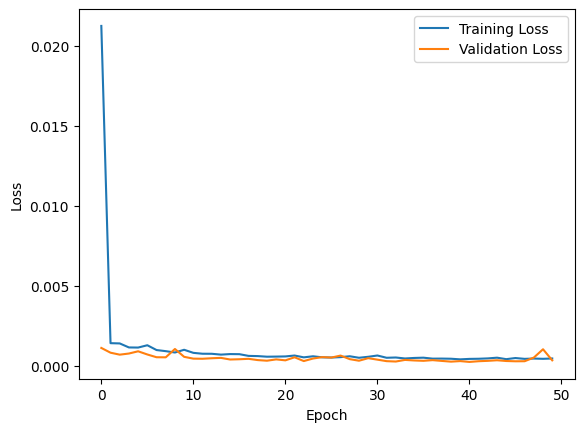

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 48, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 47, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 23, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          90,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 290,117 (1.11 MB)

 Trainable params: 96,705 (377.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 193,412 (755.52 KB)

In [20]:
# Calculate R2 score and MSE for training data
train_r2 = r2_score(y_train.reshape(-1), train_predictions.reshape(-1))
train_mse = mean_squared_error(y_train.reshape(-1), train_predictions.reshape(-1))

# Calculate R2 score and MSE for testing data
test_r2 = r2_score(y_test.reshape(-1), test_predictions.reshape(-1))
test_mse = mean_squared_error(y_test.reshape(-1), test_predictions.reshape(-1))

# Print evaluation metrics
print(f'Training R2 Score: {train_r2}')
print(f'Training Mean Squared Error: {train_mse}')
print(f'Testing R2 Score: {test_r2}')
print(f'Testing Mean Squared Error: {test_mse}')


Training R2 Score: 0.9957470667900948
Training Mean Squared Error: 0.0003256621022039192
Testing R2 Score: 0.9955427098166255
Testing Mean Squared Error: 0.0003248319827690914


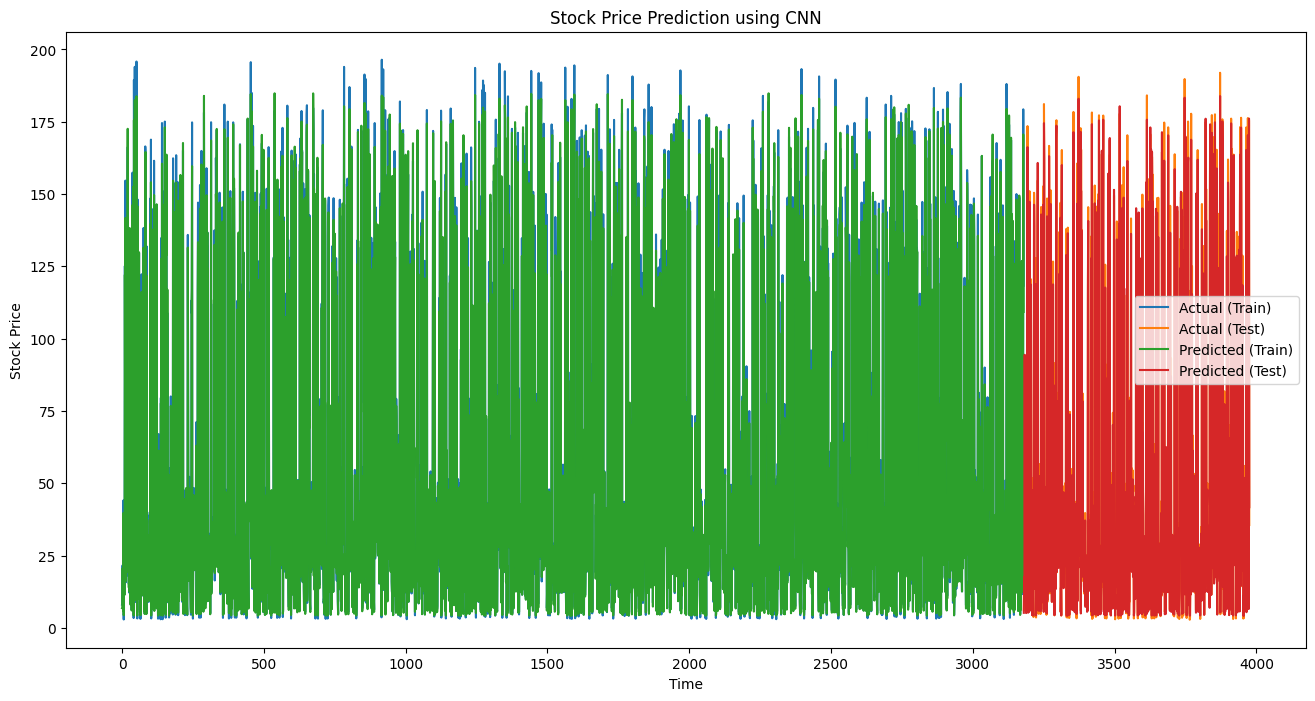

In [21]:
# Plot predictions
plt.figure(figsize=(16, 8))
plt.plot(np.arange(len(y_train)), scaler.inverse_transform(y_train.reshape(-1, 1)), label='Actual (Train)')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual (Test)')
plt.plot(np.arange(len(y_train)), scaler.inverse_transform(train_predictions), label='Predicted (Train)')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(test_predictions), label='Predicted (Test)')
plt.title('Stock Price Prediction using CNN')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()